In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import validation_curve
from sklearn.metrics import f1_score
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

We develop here how we have treated the data in order to fit the model ini the best way possible using KNN

In [10]:
df_train = pd.read_csv('data/train.csv')
df_train.dropna(subset=['Y'], inplace=True)

X = df_train.drop('Y', axis = 1)
y = df_train['Y']


X_test_prueb = pd.read_csv('data/Xtest.csv')
df_train.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Y
0,3215.0,206.0,8.0,127.0,14.0,5588.0,215.0,248.0,168.0,1057.0,T1,T29,1.0
1,3022.0,18.0,7.0,0.0,0.0,3012.0,215.0,226.0,148.0,1476.0,T1,T23,1.0
2,3008.0,18.0,19.0,382.0,92.0,4715.0,201.0,197.0,127.0,3616.0,T1,T29,1.0
3,2595.0,296.0,24.0,85.0,28.0,1252.0,144.0,224.0,216.0,780.0,T3,T33,6.0
4,3261.0,87.0,4.0,42.0,-2.0,3719.0,226.0,233.0,142.0,3784.0,T1,T38,7.0


In [11]:

numeric_variables_missing = ['X1','X2','X3', 'X4', 'X5', 'X6','X7', 'X8', 'X9', 'X10']

categorical_variables_missing = ['X11','X12']

categorical_variables = ['X11', 'X12']
imputer = SimpleImputer(strategy='mean')
X[numeric_variables_missing] = imputer.fit_transform(X[numeric_variables_missing])
imputer = SimpleImputer(strategy='most_frequent')
X[categorical_variables_missing] = imputer.fit_transform(X[categorical_variables_missing])

X['X11'] = X['X11'].astype('category')
X['X12'] = X['X12'].astype('category')

In [12]:
X = X.astype({'X11':'category', 'X12': 'category'})
X_test_prueb = X_test_prueb.astype({'X11':'category', 'X12':'category'})

We split our initial trainning set in order to have the chance of testing how the model predicts in new data, also to aviod having overfitting.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train_num  = X_train[['X1','X3','X4','X6', 'X10', 'X7']]
X_train_cat = X_train[['X11']]
X_test_num = X_test[['X1','X3','X4','X6', 'X10', 'X7']]
X_test_cat = X_test[['X11']]


In [15]:
ohe = OneHotEncoder(sparse=False)
X_train_categorical_encoded = ohe.fit_transform(X_train_cat)
X_test_cat_encoded = ohe.fit_transform(X_test_cat)

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [16]:
X_train_num = np.concatenate((X_train_num, X_train_categorical_encoded), axis=1)
X_test_num = np.concatenate((X_test_num, X_test_cat_encoded), axis=1)

In [17]:
param_grid_nb ={}
nb = GaussianNB()

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)
model = RandomizedSearchCV(nb, param_grid_nb, scoring='neg_log_loss', **default_grid_params)

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

model.fit(X_train_num, y_train)

y_pred = model.predict(X_test_num)


y_pred_proba = model.predict_proba(X_train_num)
pred_prob_test = pd.DataFrame(model.predict_proba(X_test_num))
pred_prob_test.rename(columns = {0: 'Y_1', 1: 'Y_2', 2: 'Y_3', 3: 'Y_4', 4: 'Y_5', 5:'Y_6', 6:'Y_7'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)

test_log_loss = log_loss(y_train, y_pred_proba, labels=model.classes_)
print('Log loss:', test_log_loss)
print(f'Best hyperparameters: {model.best_params_}')

c:\Users\cmari\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Log loss: 1.3758880939276812
Best hyperparameters: {}


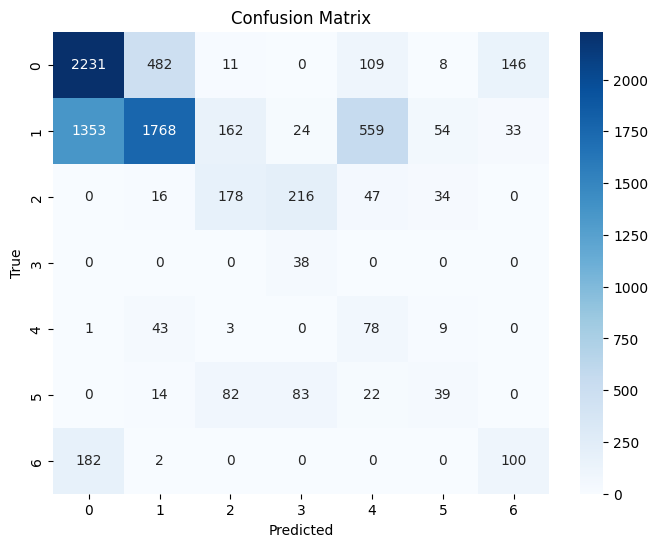

In [19]:
y_pred = model.predict(X_test_num)

#In order to plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#THis is for giving a specific color and plottinf it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()